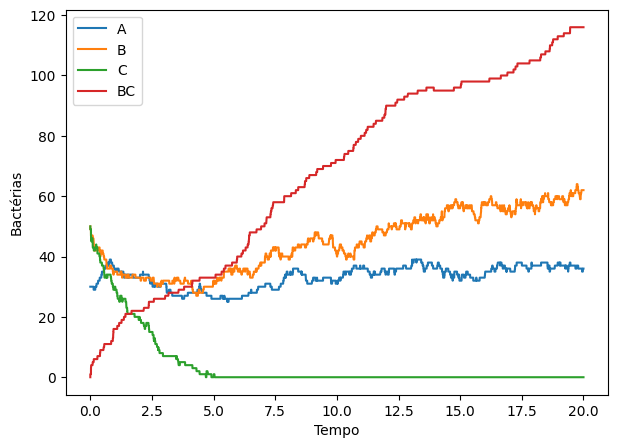

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from grid import *
from bacteria import *
from grid import *
from event import *
from obsrand import *
from cap import *


# Função para inicializar a simulação, criando uma grid e distribuindo as bactérias A, B e C aleatoriamente.
def initialize_simulation(N, NA, NB, NC, F, Q):
    grid = create_grid(N)
    
    # ID das bactérias
    bacteria_count = 0

    # Distribuição das bactérias A
    for _ in range(NA):
        x, y = np.random.randint(N, size=2)
        while len(grid[x][y]['bacteria']) >= Q:
            x, y = np.random.randint(N, size=2)
        bacteria = create_bacteria(bacteria_count, 'A', F, x, y)
        add_bacteria_to_cell(grid, x, y, bacteria)
        bacteria_count += 1

    # Distribuição das bactérias B
    for _ in range(NB):
        x, y = np.random.randint(N, size=2)
        while len(grid[x][y]['bacteria']) >= Q:
            x, y = np.random.randint(N, size=2)
        bacteria = create_bacteria(bacteria_count, 'B', F, x, y)
        add_bacteria_to_cell(grid, x, y, bacteria)
        bacteria_count += 1

    # Distribuição das bactérias C
    for _ in range(NC):
        x, y = np.random.randint(N, size=2)
        while len(grid[x][y]['bacteria']) >= Q:
            x, y = np.random.randint(N, size=2)
        bacteria = create_bacteria(bacteria_count, 'C', F, x, y)
        add_bacteria_to_cell(grid, x, y, bacteria)
        bacteria_count += 1

    
    return grid


# Função principal para executar a simulação
def run_simulation(N, NA, NB, NC, TS, TD, K, TR, TA, TM, TF, TRP, F, Q):

    # Inicializa a grade e a CAP (lista de eventos futuros)
    grid = initialize_simulation(N, NA, NB, NC, F, Q)
    cap = newc()
    time_elapsed = 0
    bacteria_count = NA + NB + NC

    # Contadores de bactérias
    count_A = [NA]
    count_B = [NB]
    count_C = [NC]
    count_BC = [0]

    # Contadores de tempo
    x_trace = [0]

    # Loop principal da simulação, executado até o tempo total TS ser atingido
    while time_elapsed < TS:

        # Limpa o CAP
        cap = newc()
        
        # Atualiza a CAP e adiciona eventos de acordo com o enunciado
        for i in range(len(grid)):
            for j in range(len(grid[i])):
                cell = grid[i][j]
                for bacteria in cell['bacteria']:
                    cap = addE(cap, evt(time_elapsed + exprandom(TD), 'move', (bacteria, grid, K, Q)))
                    cap = addE(cap, evt(time_elapsed + exprandom(TR), 'reproduce', (bacteria, grid, Q)))
                    if bacteria.species == 'B' or bacteria.species == 'C':
                        cap = addE(cap, evt(time_elapsed + exprandom(TF), 'fuse', (bacteria, grid, Q)))
                    cap = addE(cap, evt(time_elapsed + exprandom(TA), 'consume_food', (bacteria, grid)))
                    cap = addE(cap, evt(time_elapsed + exprandom(TM), 'die', (bacteria, grid)))
        
        cap = addE(cap, evt(time_elapsed + exprandom(TRP), 'replenish_food', (bacteria, grid)))

        # Processa o próximo evento
        next_event = nextE(cap)

        # Atualiza o tempo para o próximo evento
        event_time, event_type, event_data = event.time(next_event), event.kind(next_event), event.counts(next_event)

        # Atualiza a bacteria e a grid de acordo com o tipo de evento
        bacteria, grid = event_data[0], event_data[1]

        # Evento de movimento de bactéria (move a bactéria e atualiza a grid)
        if event_type == 'move':
            # move a bacteria para uma célula vizinha aleatória
            dx, dy = np.random.randint(-K, K+1, size=2)
            move_bacteria(grid, bacteria, dx, dy, Q)

        # Evento de reprodução de bactéria (cria uma nova bactéria e atualiza a grid)
        elif event_type == 'reproduce':
            # Se tiver 2 ou mais bactérias da mesma espécie e a célula não estiver cheia, cria uma nova bactéria
            if len([b for b in grid[bacteria.x][bacteria.y]['bacteria'] if b.species == bacteria.species]) >= 2 and len(grid[bacteria.x][bacteria.y]['bacteria']) < Q:
                new_bacteria = create_bacteria(bacteria_count, bacteria.species, F, bacteria.x, bacteria.y)
                add_bacteria_to_cell(grid, bacteria.x, bacteria.y, new_bacteria)
                bacteria_count += 1
                if bacteria.species == 'A':
                    count_A[-1] += 1
                elif bacteria.species == 'B':
                    count_B[-1] += 1
                elif bacteria.species == 'C':
                    count_C[-1] += 1
                else:
                    count_BC[-1] += 1
        
        # Evento de fusão de bactérias (remove as bactérias da grid e cria uma nova bactéria)
        elif event_type == 'fuse':
            # Se especie da bactéria for B, seleciona uma C, e vice-versa
            if bacteria.species == 'B':
                partner_species = 'C'
            else:
                partner_species = 'B'

            # Se tiver uma bactéria da espécie selecionada, remove as duas e cria uma nova bactéria BC
            partner = [b for b in grid[bacteria.x][bacteria.y]['bacteria'] if b.species == partner_species]
            if partner:
                selected_partner = np.random.choice(partner)
                die(grid, bacteria)
                die(grid, selected_partner)
                if bacteria.species == 'B':
                    count_B[-1] -= 1
                    count_C[-1] -= 1
                else:
                    count_C[-1] -= 1
                    count_B[-1] -= 1
                new_bacteria = create_bacteria(bacteria_count, 'BC', F, bacteria.x, bacteria.y)
                add_bacteria_to_cell(grid, bacteria.x, bacteria.y, new_bacteria)
                bacteria_count += 1
                count_BC[-1] += 1

        # Evento de alimentação de bactéria (remove comida da célula e aumenta a quantidade de comida da bactéria)
        elif event_type == 'consume_food':
            # Se a espécie da bactéria for A, ela pode consumir a bacteria B ou C, ou comida da célula e se não tiver comida, morre
            if bacteria.species == 'A':
                prey = [b for b in grid[bacteria.x][bacteria.y]['bacteria'] if b.species in ['B', 'C']]
                if prey:
                    selected_prey = np.random.choice(prey)
                    die(grid, selected_prey)
                    if selected_prey.species == 'B':
                        count_B[-1] -= 1
                    else:
                        count_C[-1] -= 1
                elif bacteria.food > 0:
                    consume_food(bacteria, 1)
                else:
                    die(grid, bacteria)
                    count_A[-1] -= 1

            # Se a espécie da bactéria for B ou C, ela pode consumir comida da célula ou comida da própria bactéria e se não tiver comida, morre
            else:
                if grid[bacteria.x][bacteria.y]['food'] > 0:
                    consume_food_in_cell(grid, bacteria.x, bacteria.y, 1)
                elif bacteria.food > 0:
                    consume_food(bacteria, 1)
                else:
                    die(grid, bacteria)
                    if bacteria.species == 'B':
                        count_B[-1] -= 1
                    elif bacteria.species == 'C':
                        count_C[-1] -= 1
                    elif bacteria.species == 'BC':
                        count_BC[-1] -= 1

        # Evento de morte de bactéria (remove a bactéria da grid)
        elif event_type == 'die':
            remove_bacteria_from_cell(grid, bacteria.x, bacteria.y, bacteria)
            if bacteria.species == 'A':
                count_A[-1] -= 1
            elif bacteria.species == 'B':
                count_B[-1] -= 1
            else:
                count_C[-1] -= 1
        
        # Evento de repor comida na grelha (repor comida na célula)
        elif event_type == 'replenish_food':
            replenish_food(grid)


        # Atualiza o tempo
        time_elapsed = event_time


        # Atualiza os contadores de bactérias
        
        count_A.append(count_A[-1])
        count_B.append(count_B[-1])
        count_C.append(count_C[-1])
        count_BC.append(count_BC[-1])

        x_trace.append(time_elapsed)    


    # Plot dos resultados, mostrando apenas contagens positivas
    plt.figure(figsize=(7, 5))
    plt.plot(x_trace, np.clip(count_A, 0, None), label='A')
    plt.plot(x_trace, np.clip(count_B, 0, None), label='B')
    plt.plot(x_trace, np.clip(count_C, 0, None), label='C')
    plt.plot(x_trace, np.clip(count_BC, 0, None), label='BC')
    plt.xlabel('Tempo')
    plt.ylabel('Bactérias')
    plt.legend()
    plt.show()

# Executa a simulação com os parâmetros fornecidos
run_simulation(N = 10, NA = 30, NB = 50, NC = 50, TS = 20, TD = 2, K = 5, TR = 1, TA = 5, TM = 5, TF = 1, TRP = 2, F = 2, Q = 4)



Este código implementa uma simulação de bactérias em uma grade, onde três espécies de bactérias (A, B, C, BC) interagem entre si e com o ambiente. O objetivo é analisar o comportamento dessas bactérias ao longo do tempo, considerando eventos como movimento, reprodução, fusão, alimentação e morte.

O código é composto por várias funções que lidam com diferentes aspectos da simulação. Abaixo, apresentamos um breve resumo do funcionamento de cada função e, em seguida, uma descrição do fluxo geral da simulação.

**Funções**:

    initialize_simulation: Inicializa a simulação criando uma grade e distribuindo as bactérias A, B e C aleatoriamente.

    run_simulation: Função principal que executa a simulação, gerenciando os eventos e atualizando a grade e as bactérias.

    Outras funções importadas de outros módulos são usadas para gerenciar aspectos específicos da simulação, como a criação e manipulação de bactérias, células da grade e eventos.
**Fluxo geral da simulação**:
    A simulação é iniciada chamando a função run_simulation com os parâmetros fornecidos.

    A função initialize_simulation é chamada para criar a grade e distribuir as bactérias aleatoriamente.

    O loop principal da simulação é executado até que o tempo total (TS) seja atingido.

    Durante o loop principal, eventos são gerados e processados. Os eventos possíveis incluem movimento de bactérias, reprodução, fusão, alimentação e morte.

    O estado da simulação é atualizado de acordo com o tipo de evento e o tempo decorrido.

    Os contadores de bactérias são atualizados a cada iteração do loop.

    Após o término do loop principal, os resultados são plotados em um gráfico que mostra a quantidade de bactérias de cada espécie ao longo do tempo.

A simulação é executada usando os parâmetros fornecidos, que determinam as características do ambiente e das bactérias, bem como as regras de interação entre elas. O resultado é um gráfico que ilustra a dinâmica das populações de bactérias ao longo do tempo, permitindo análises e comparações das espécies de bactérias e seus comportamentos em diferentes cenários.

No código, há diversos tipos de eventos que ocorrem durante a simulação e afetam as bactérias e o ambiente. Os eventos são gerados e processados no loop principal da função run_simulation. 
Vamos analisar cada tipo de evento:

    1.
        Movimento de bactéria (move): Este evento move uma bactéria para uma célula vizinha aleatória. O evento é gerado com um tempo aleatório determinado por exprandom(TD). A função move_bacteria é chamada para mover a bactéria na grade e atualizar sua posição.

    2.
        Reprodução de bactéria (reproduce): Este evento ocorre quando uma bactéria se reproduz, criando uma nova bactéria da mesma espécie na mesma célula, desde que haja pelo menos duas bactérias da mesma espécie e a célula não esteja cheia. O evento é gerado com um tempo aleatório determinado por exprandom(TR). Se a reprodução ocorrer, uma nova bactéria é criada e adicionada à célula usando a função add_bacteria_to_cell.

    3.
        Fusão de bactérias (fuse): Este evento ocorre quando uma bactéria B se funde com uma bactéria C na mesma célula, formando uma nova bactéria BC. O evento é gerado com um tempo aleatório determinado por exprandom(TF). Se a fusão ocorrer, as bactérias B e C são removidas da célula usando a função die, e uma nova bactéria BC é criada e adicionada à célula.

    4.
        Alimentação de bactéria (consume_food): Este evento ocorre quando uma bactéria consome comida. Bactérias A podem consumir bactérias B e C, enquanto bactérias B e C podem consumir comida das células. O evento é gerado com um tempo aleatório determinado por exprandom(TA). Dependendo da espécie da bactéria, a função consume_food ou consume_food_in_cell é chamada para atualizar a quantidade de comida da bactéria ou da célula. Se a bactéria não tiver comida disponível, ela morre.

    5.
        Morte de bactéria (die): Este evento ocorre quando uma bactéria morre, seja por falta de comida ou por outros motivos. O evento é gerado com um tempo aleatório determinado por exprandom(TM). A função die é chamada para remover a bactéria da célula e atualizar a grade.

    6.
        Reposição de comida (replenish_food): Este evento ocorre periodicamente para repor a comida nas células da grade. O evento é gerado com um tempo aleatório determinado por exprandom(TRP). A função replenish_food é chamada para adicionar comida às células.

Esses eventos são gerenciados no loop principal da função run_simulation, onde o próximo evento é processado e o estado da simulação é atualizado de acordo com o tipo de evento e o tempo decorrido. A quantidade de bactérias de cada espécie é rastreada ao longo do tempo, permitindo a análise da dinâmica das populações de bactérias.

**FAQ do codigo**:

1. O que faz o modulo np?

    O módulo np é um módulo do Python que contém funções e objetos para trabalhar com matrizes e vetores. Ele é usado para criar e manipular matrizes e vetores, bem como para realizar operações matemáticas com eles.

    1. O que faz esta linha de codigo ( x, y = np.random.randint(N, size=2) )?

        Esta linha de código gera um número aleatório entre 0 e N-1, que é usado para selecionar uma célula aleatória da grade.

    2. dx, dy = np.random.randint(-K, K+1, size=2) ?

        Esta linha de código gera um número aleatório entre -K e K, que é usado para selecionar uma célula vizinha aleatória da célula atual.

    3. np.random.choice(partner) ?

        Esta linha de código seleciona uma bactéria aleatória da lista de bactérias vizinhas.
    
    4. np.clip(count_A, 0, None) ?

        Esta linha de código limita o valor mínimo de count_A a 0.